# Chapter 8 Exercises

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

###  Apply the SARIMA(p,d,q)(P,D,Q)m model on the Johnson & Johnson dataset

In chapter 7 we applied an ARIMA(p,d,q) model to the Johnson & Johnson dataset to
forecast the quarterly EPS over a year. Now use the SARIMA(p,d,q)(P,D,Q)m model on
the same dataset, and compare its performance to the ARIMA model.
1. Use time series decomposition to identify the presence of a periodic pattern.
2. Use the optimize_SARIMA function and select the model with the lowest AIC.
3. Perform residual analysis.
4. Forecast the EPS for the last year, and measure the performance against the
ARIMA model. Use the MAPE. Is it better?

#### Dataset

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/AppliedTimeSeriesAnalysisWithPython/main/data/jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    84 non-null     object 
 1   data    84 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


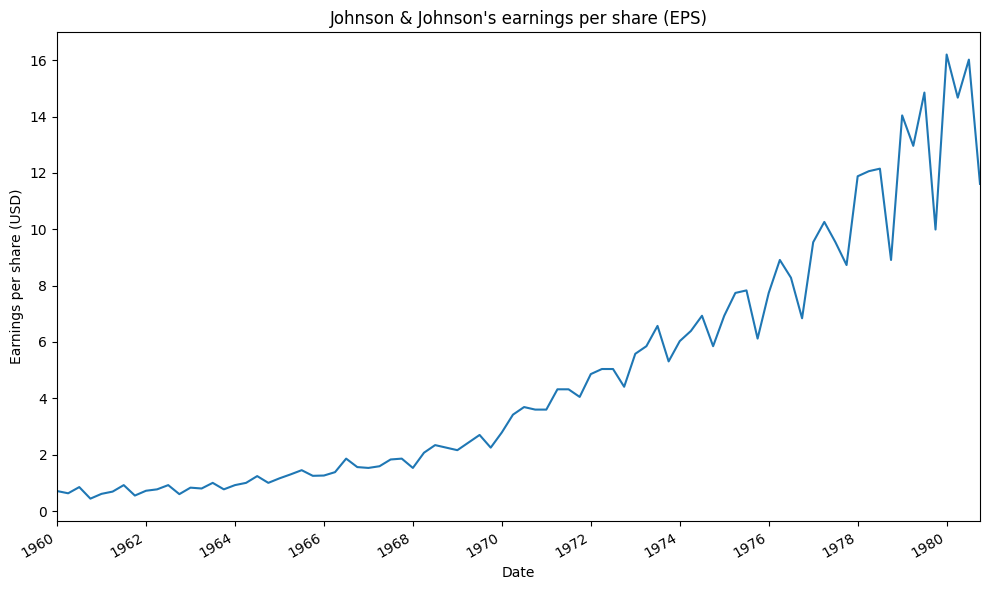

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.set_title("Johnson & Johnson's earnings per share (EPS)")
ax.set_xlim(0, 83)  # 84 points

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

#### 1. Use time series decomposition to identify the presence of a periodic pattern.

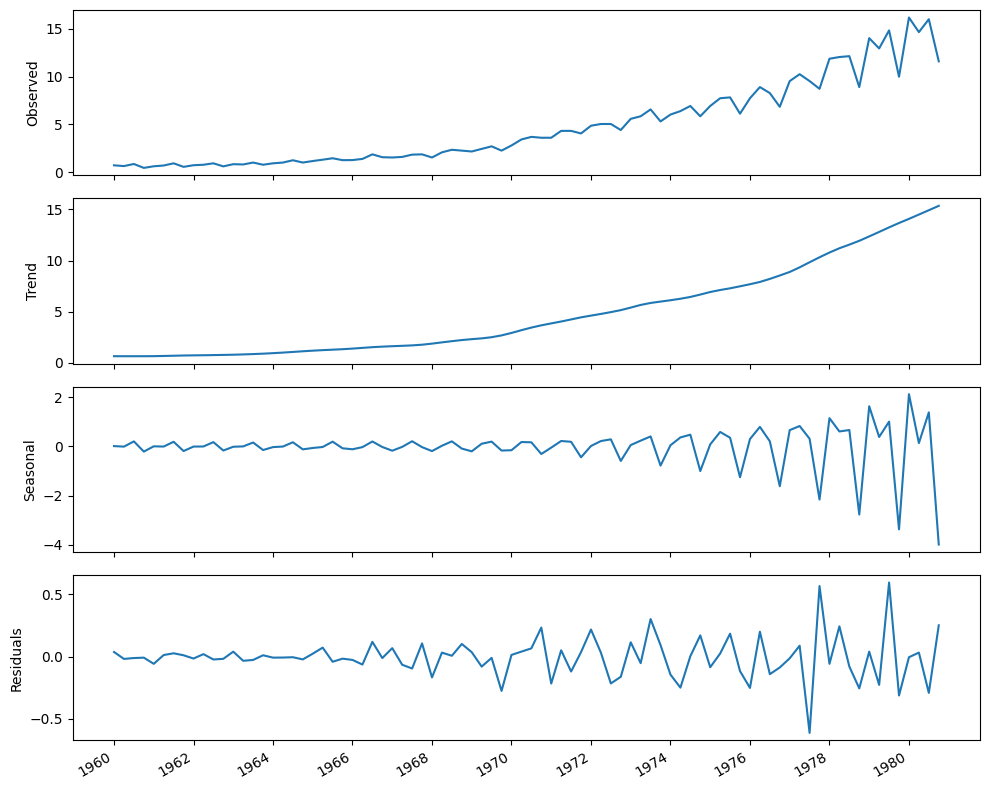

In [10]:
decomposition = STL(df['data'], period=4).fit()    # Period is 4 since we have quarterly data (3 and 3 months)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

#### 2. Use the optimize_SARIMA function and select the model with the lowest AIC.

In [12]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df['data'])

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: 2.7420165734574766
p-value: 1.0

p-value > alpha; H0: Not Stationary


The series is not stationary, so let's apply differencing.

In [14]:
# First-Order differencing
df_diff1 = np.diff(df['data'], n=1)

ad_fuller_result1 = adfuller(df_diff1)

print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
print()

if ad_fuller_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -0.4074097636380437
p-value: 0.9088542416911309

p-value > alpha; H0: Not Stationary


The series is still not stationary. Let's try seasonal differencing now.

In [16]:
# Second-Order differencing with Seasonality
sea_diff2 = np.diff(df_diff1, n=4)  # Seasonal differencing. Since we have 3x 3 months (quarterly data) 

ad_fuller_result2 = adfuller(sea_diff2)

print(f'ADF Statistic: {ad_fuller_result2[0]}')
print(f'p-value: {ad_fuller_result2[1]}')
print()

if ad_fuller_result2[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -6.032499262649851
p-value: 1.407057105567291e-07

p-value < alpha; Ha: Stationary


    Therefore, we set d = 1 and D = 1.

In [18]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [19]:
# Keep the last year to test the predictions
train = df[:-4]
test = df[-4:]

In [20]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

d = 1   #<==== one round of differencing
D = 1   #<==== one round of seasonal differencing to Stationary
s = 4   #<==== We have quarterly data, so 4 data points per seasonal cycle

SARIMA_result_df = optimize_SARIMA(train['data'], SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 0, 2, 1)",88.838003
1,"(1, 2, 0, 0)",89.609996
2,"(3, 1, 0, 0)",89.677549
3,"(1, 3, 0, 0)",89.734025
4,"(2, 2, 0, 0)",90.178107
...,...,...
251,"(0, 0, 3, 2)",136.748921
252,"(0, 0, 2, 3)",136.768596
253,"(0, 0, 0, 0)",137.133568
254,"(0, 0, 1, 3)",137.761947


    p = 3
    q = 0
    P = 2
    Q = 1
    d = 1
    D = 1
    s = 4
    
    The model with the lowest AIC is a SARIMA(3,1,0)(2,1,1,4) model.

#### 3. Perform residual analysis.

In [23]:
# Define the SARIMA model with non-seasonal order (p=3, d=1, q=0) and seasonal order (P=2, D=1, Q=1, s=4)
SARIMA_model = SARIMAX(train['data'], order=(3,1,0), seasonal_order=(2,1,1,4), simple_differencing=False) 

# Fit the model
SARIMA_model_fit = SARIMA_model.fit(disp=False)  

# Display Summary
SARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                data   No. Observations:                   80
Model:             SARIMAX(3, 1, 0)x(2, 1, [1], 4)   Log Likelihood                 -37.419
Date:                             Tue, 18 Feb 2025   AIC                             88.838
Time:                                     11:02:21   BIC                            105.060
Sample:                                          0   HQIC                            95.315
                                              - 80                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8194      0.115     -7.131      0.000      -1.045      -0.594
ar.L2         -0.3625      0.142     -2.555      0.011      -0.641      -0.084
ar.L3         -0.4627      0.112     -4.124      0.000      -0.683      -0.243
ar.S.L4       -1.1178      0.181     -6.181      0.000      -1.472      -0.763
ar.S.L8       -0.3311      0.093     -3.557      0.000      -0.513      -0.149
ma.S.L4        0.9877      1.128      0.875      0.381      -1.224       3.199
sigma2         0.1453      0.145      1.000      0.317      -0.139       0.430
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                30.24
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):              42.14   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

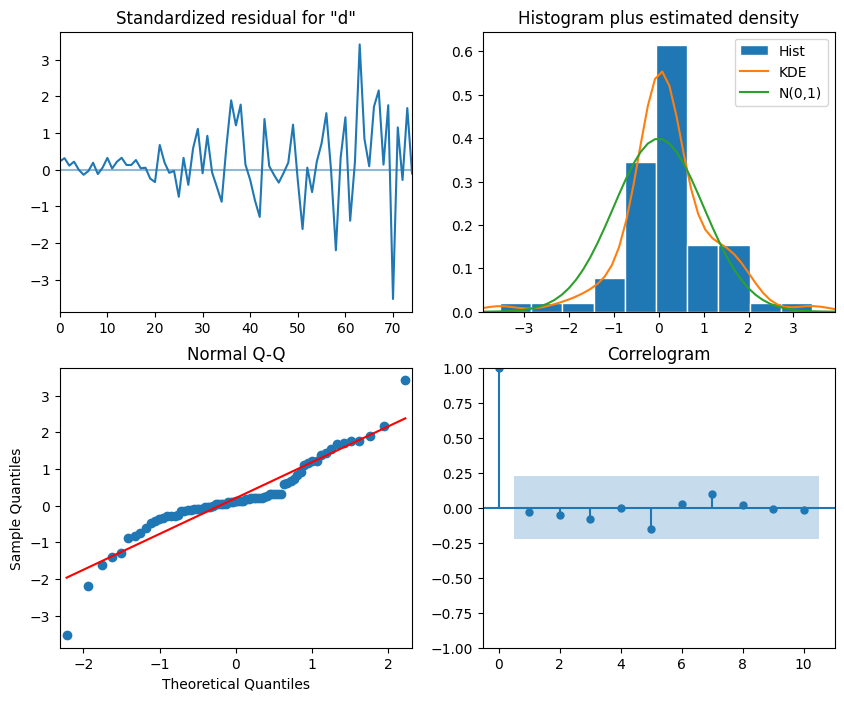

In [24]:
# Diagnostic plots for the model, including residuals and other model checks
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [25]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Extract the residuals (errors) from the fitted model
residuals_sea = SARIMA_model_fit.resid 

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals_sea = acorr_ljungbox(residuals_sea, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals_sea['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals_sea

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.089750,0.764495
2,0.263190,0.876696
3,1.156959,0.763345
4,1.182711,0.880937
5,2.901974,0.715095
6,2.994548,0.809531
7,3.843270,0.797642
8,3.898550,0.866159
9,3.905246,0.917538
10,3.930030,0.950448


#### 4. Forecast the EPS for the last year, and measure the performance against the ARIMA model. Use the MAPE. Is it better?

In [27]:
# Generate predictions for the test set using the fitted SARIMA model, for timesteps 80 to 83
SARIMA_pred = SARIMA_model_fit.get_prediction(80, 83).predicted_mean

# Assign the predicted values to a new column 'SARIMA_pred' in the test dataframe
test['SARIMA_pred'] = SARIMA_pred

# Display the dataframe
test

,date,data,SARIMA_pred
80,1980-01-01,16.20,16.526812
81,1980-04-01,14.67,14.098243
82,1980-07-02,16.02,17.278456
83,1980-10-01,11.61,11.387538


In [28]:
# Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [29]:
# Calculate the MAPE for the forecast
mape_SARIMA = mape(test['data'], test['SARIMA_pred'])

# Display MAPE result
print(f'MAPE for SARIMA Forecast: {mape_SARIMA:.2f}')

MAPE for SARIMA Forecast: 3.92


In chapter 7, we achieved a MAPE of 2.85% with an ARIMA model, while the SARIMA model achieves a MAPE of 3.92%. In this case, the SARIMA model does not perform better on our test set. It can be interesting to have a larger test set and perform rolling forecasts to evaluate both models. However, our dataset is very limited.